
# A/B Test Sample Size & Power (Two-Sided Two-Proportion, H₁: p₂ ≠ p₁)

This notebook is a complete, ready-to-run template for planning and visualizing a **two-sided** two-proportion z-test
(e.g., for pricing or UX changes where you want to detect either an increase or a decrease in conversion). It provides:

- **Design primer**: α, power, MDE, Type I/II errors, and why two-sided uses `Z_{1-α/2}`
- **Two sample-size pathways**:  
  1) **Raw proportions (pooled)** closed-form formula  
  2) **Cohen’s h** (variance-stabilizing effect size via `arcsin(sqrt(p))`)
- **`statsmodels` solver** for cross-checking (uses Cohen’s h under the hood)
- **Visuals** to build intuition:  
  - Sample size vs. MDE (absolute points)  
  - Cohen’s h vs. baseline for a fixed absolute difference  
  - Power vs. per-group n for the chosen effect

> **When to prefer two-sided?** When you plausibly care about any material change (up or down), or you did not pre-register
> a directional hypothesis. Two-sided tests are more conservative for the same α, requiring a larger n than one-sided.



## Design Primer: What & Why (Two-Sided)

- **Baseline (p1):** Historical estimate of your current conversion rate.  
- **MDE (Minimum Detectable Effect):** Smallest uplift (or drop) worth acting on.  
  - **Absolute**: `p2 = p1 + Δ` (e.g., +0.02 = +2 percentage points).  
  - **Relative**: `p2 = p1 × (1 + r)` (e.g., +0.10 = +10% vs p1).  
- **Significance (α):** Type I error rate (false positive).  
  - **Two-sided** uses the critical value `Z_{1-α/2}` (splitting α across both tails).  
- **Power (1 − β):** Probability to detect the effect if it truly exists (controls Type II error).  
- **Why two formulas?**  
  - **Raw pooled proportions**: precise and intuitive if you know p1 and target p2.  
  - **Cohen’s h**: standardizes effects on [0,1] via `arcsin(sqrt(p))`, making equal absolute differences comparable across baselines.

**Guardrails & practice on large sites**: randomize by user, check SRM, consider CUPED / covariate adjustment, run across weekly cycles,
and define a conversion maturation window (e.g., allow delayed bookings to materialize before final analysis).


In [1]:

# ------------------------------------------------------------
# IMPORTS
# ------------------------------------------------------------
import math
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

try:
    from scipy.stats import norm
    def z_quantile(prob):
        return norm.ppf(prob)
except Exception:
    def z_quantile(prob):
        return math.sqrt(2) * math.erfinv(2*prob - 1)

POWER_SOLVER = NormalIndPower()


In [2]:

# ------------------------------------------------------------
# HELPERS: Transform MDE -> p2, manual formulas, statsmodels
# ------------------------------------------------------------
def resolve_p2_from_mde(p1, mde, mde_type="absolute"):
    if mde_type == "absolute":
        p2 = p1 + mde
    elif mde_type == "relative":
        p2 = p1 * (1 + mde)
    else:
        raise ValueError("mde_type must be 'absolute' or 'relative'")
    return float(np.clip(p2, 1e-8, 1-1e-8))

def n_per_group_raw_two_sided(p1, p2, alpha=0.05, power=0.8):
    z_alpha_over_2 = z_quantile(1 - alpha/2)
    z_power        = z_quantile(power)
    p_pool         = 0.5 * (p1 + p2)
    term_null      = math.sqrt(2 * p_pool * (1 - p_pool))
    term_alt       = math.sqrt(p1*(1 - p1) + p2*(1 - p2))
    diff           = abs(p2 - p1)
    n              = ((z_alpha_over_2*term_null + z_power*term_alt)**2) / (diff**2)
    return n

def cohens_h(p1, p2):
    return 2.0 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p2)))

def n_per_group_h_two_sided(p1, p2, alpha=0.05, power=0.8):
    z_alpha_over_2 = z_quantile(1 - alpha/2)
    z_power        = z_quantile(power)
    h              = abs(cohens_h(p1, p2))
    n              = 2.0 * ((z_alpha_over_2 + z_power)**2) / (h**2)
    return n

def n_per_group_statsmodels_two_sided(p1, p2, alpha=0.05, power=0.8):
    h = proportion_effectsize(p1, p2)
    n = POWER_SOLVER.solve_power(effect_size=abs(h),
                                 alpha=alpha,
                                 power=power,
                                 ratio=1.0,
                                 alternative="two-sided")
    return n


In [4]:

# ------------------------------------------------------------
# VISUAL 1: Sample size vs absolute MDE (two-sided)
# ------------------------------------------------------------
def plot_n_vs_mde_two_sided(p1, alpha=0.05, power=0.8, mde_min=0.005, mde_max=0.10, points=60):
    mdes = np.linspace(mde_min, mde_max, points)
    n_raw_curve, n_h_curve = [], []
    for m in mdes:
        p2 = resolve_p2_from_mde(p1, m, "absolute")
        n_raw_curve.append(n_per_group_raw_two_sided(p1, p2, alpha, power))
        n_h_curve.append(n_per_group_h_two_sided(p1, p2, alpha, power))

    plt.figure(figsize=(8,5))
    plt.plot(mdes*100, n_raw_curve, label="Manual Raw (pooled)")
    plt.plot(mdes*100, n_h_curve, linestyle="--", label="Manual Cohen's h")
    plt.xlabel("MDE (absolute percentage points)")
    plt.ylabel("Per-group sample size (n)")
    plt.title(f"Sample Size vs. MDE (Baseline p1={p1:.0%}, alpha={alpha}, Power={power}, two-sided)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [5]:

# ------------------------------------------------------------
# VISUAL 2: Cohen's h vs baseline for a fixed absolute difference
# ------------------------------------------------------------
def plot_h_vs_baseline(abs_diff=0.05, p1_min=0.05, p1_max=0.95, points=200):
    p1_grid = np.linspace(p1_min, p1_max, points)
    h_vals  = []
    for p1 in p1_grid:
        p2 = resolve_p2_from_mde(p1, abs_diff, "absolute")
        h_vals.append(abs(cohens_h(p1, p2)))

    plt.figure(figsize=(8,5))
    plt.plot(p1_grid*100, h_vals)
    plt.xlabel("Baseline p1 (%)")
    plt.ylabel("Cohen's h (|standardized effect|)")
    plt.title(f"Cohen's h vs Baseline (Absolute diff = {abs_diff*100:.1f} pp)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [6]:

# ------------------------------------------------------------
# VISUAL 3: Power vs per-group n (two-sided)
# ------------------------------------------------------------
def plot_power_vs_n_two_sided(p1, mde, mde_type="absolute", alpha=0.05,
                              n_min=50, n_max=5000, step=50, target_power=0.8):
    p2 = resolve_p2_from_mde(p1, mde, mde_type=mde_type)
    h  = proportion_effectsize(p1, p2)

    n_grid = np.arange(n_min, n_max+1, step)
    powers = []
    for n in n_grid:
        pwr = POWER_SOLVER.power(effect_size=abs(h),
                                 nobs1=n,
                                 alpha=alpha,
                                 ratio=1.0,
                                 alternative="two-sided")
        powers.append(pwr)

    plt.figure(figsize=(8,5))
    plt.plot(n_grid, powers, label="Power vs per-group n")
    plt.axhline(y=target_power, linestyle="--", label=f"Target power = {target_power:.2f}")
    plt.xlabel("Per-group sample size (n)")
    plt.ylabel("Power (1 - beta)")
    plt.title(f"Power Curve (p1={p1:.0%}, p2={p2:.0%}, alpha={alpha}, two-sided)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



## Configure Your Test
Edit these parameters and run the next cell. Two-sided alternative is used throughout.


In [7]:

# ------------------------------------------------------------
# CONFIGURATION (EDIT THESE)
# ------------------------------------------------------------
p1_cfg       = 0.10          # baseline conversion rate (e.g., 10%)
mde_cfg      = 0.05          # MDE; if absolute -> 0.05 = +5 percentage points
mde_type_cfg = "absolute"    # 'absolute' or 'relative'
alpha_cfg    = 0.05          # significance level (two-sided)
power_cfg    = 0.80          # desired power (1 - beta)
# Two-sided alternative is used in all functions.


In [8]:

# ------------------------------------------------------------
# COMPUTE SAMPLE SIZES (all methods) & REPORT
# ------------------------------------------------------------
p2_cfg = resolve_p2_from_mde(p1_cfg, mde_cfg, mde_type=mde_type_cfg)

n_raw = n_per_group_raw_two_sided(p1_cfg, p2_cfg, alpha=alpha_cfg, power=power_cfg)
n_h   = n_per_group_h_two_sided(p1_cfg, p2_cfg, alpha=alpha_cfg, power=power_cfg)
n_sm  = n_per_group_statsmodels_two_sided(p1_cfg, p2_cfg, alpha=alpha_cfg, power=power_cfg)

n_reco = math.ceil(max(n_raw, n_h, n_sm))

print("=== DESIGN INPUTS (Two-Sided) ===")
print(f"Baseline p1:            {p1_cfg:.4f}")
print(f"Treatment p2 (target):  {p2_cfg:.4f}")
print(f"Alpha (two-sided):      {alpha_cfg}")
print(f"Power:                  {power_cfg}")

print("\n=== PER-GROUP SAMPLE SIZE (n) ===")
print(f"Manual: Raw pooled      {n_raw:.2f}")
print(f"Manual: Cohen's h       {n_h:.2f}")
print(f"statsmodels (h inside)  {n_sm:.2f}")
print(f"\nRECOMMENDED (ceil max): {n_reco} per group")


=== DESIGN INPUTS (Two-Sided) ===
Baseline p1:            0.1000
Treatment p2 (target):  0.1500
Alpha (two-sided):      0.05
Power:                  0.8

=== PER-GROUP SAMPLE SIZE (n) ===
Manual: Raw pooled      685.60
Manual: Cohen's h       680.35
statsmodels (h inside)  680.35

RECOMMENDED (ceil max): 686 per group


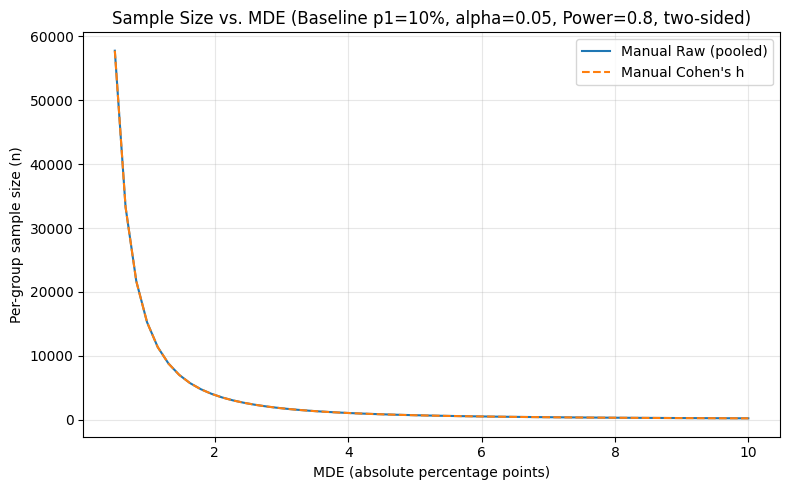

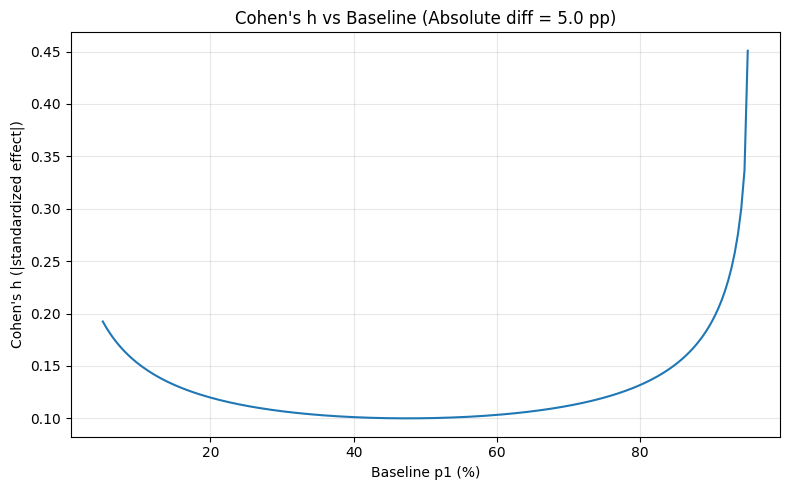

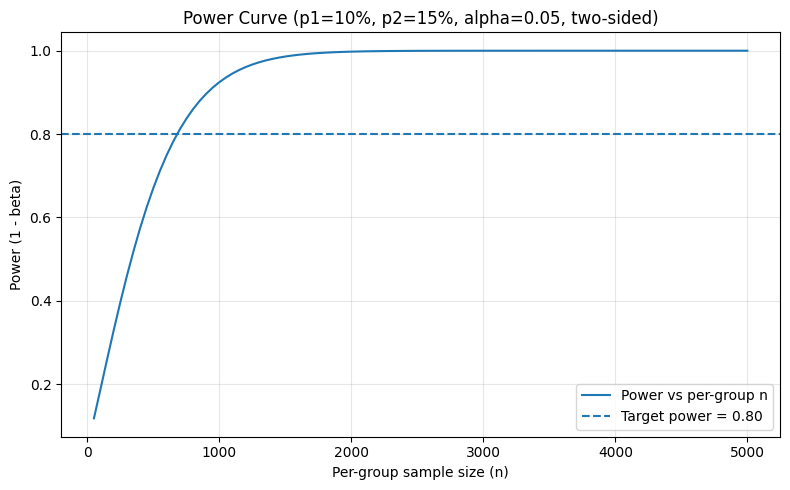

In [9]:

# ------------------------------------------------------------
# VISUALS
# ------------------------------------------------------------
plot_n_vs_mde_two_sided(p1=p1_cfg, alpha=alpha_cfg, power=power_cfg, mde_min=0.005, mde_max=0.10, points=60)
plot_h_vs_baseline(abs_diff=0.05, p1_min=0.05, p1_max=0.95, points=200)
plot_power_vs_n_two_sided(p1=p1_cfg, mde=mde_cfg, mde_type=mde_type_cfg,
                          alpha=alpha_cfg, n_min=50, n_max=5000, step=50, target_power=power_cfg)
